## User Manual (very simple)

My Medium Article on this:
- https://medium.com/@houfuchen0702/how-i-tracked-my-spending-by-openai-api-with-diy-flexibility-457da688b264
-


### Step 1. Download your spending as a csv, from the online banking website

### Step 2. Drag the CSV file into the repo

### Step 3. Almost there, you just need to change `file_path` and `openai.api_key`

### Step 4.RUN!




In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00


In [4]:
import openai

Monthly Deposit Sources:
            Description       In
0  CANADA           PRO    80.83
1  CDACARBONREBATE  CCR   140.00
2  GST              GST    85.00
3  INTEREST CREDIT          0.04
4  U of T           PAY  2823.64


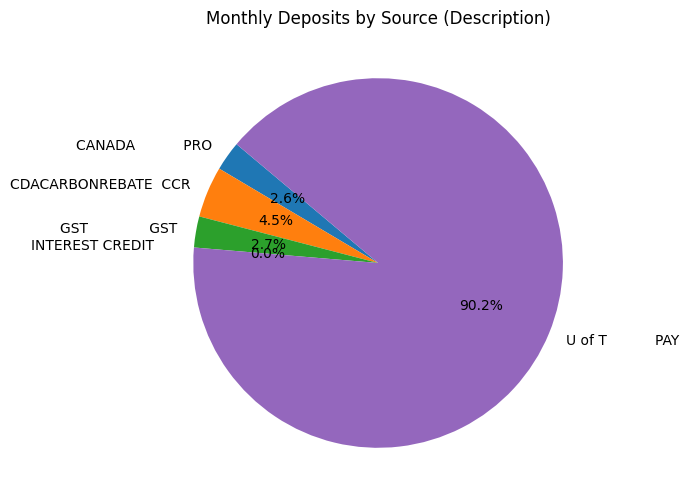

Monthly Spending Summary by Category:
        Category  Total Expenses
0      Etransfer         1966.52
1     Food/Drink          461.34
2          Other          325.86
3       Shopping          292.17
4  Subscriptions           75.69
5           Uber          126.90


<ipython-input-18-f78faa349cbc>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenses['Category'] = expenses['Description'].apply(categorize_with_chatgpt)


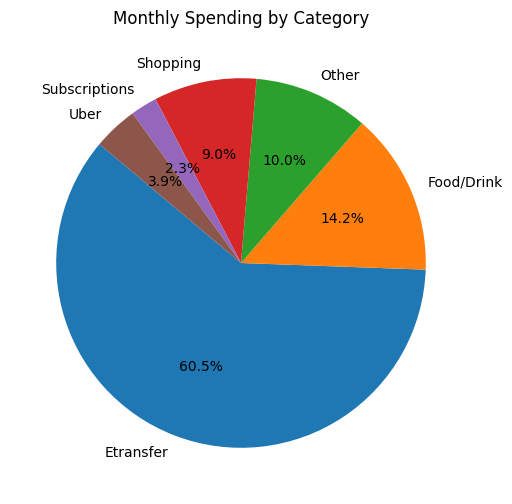

In [18]:
openai.api_key = "" # put your openai api key here

MyCategories = ['Food/Drink', 'Shopping', 'Uber', 'Subscriptions', 'Rent', 'Etransfer', 'Other'] # feel free to DIY into different categories!!
Rent = 1600
OWN_ACCOUNTS = ['6707061', '6652668', '6655489']
CREDIT_TRANSFER_KEYWORDS = ["TFR-TO C/C"]
EXCLUDE_DEPOSIT_DESCRIPTIONS = ["PAYMENT - THANK YOU"]


# Step 1: Load and standardize data from each account file
# don't fill na, because when out is 0, means its a in, vice versa
# Load and standardize data from each account file
def load_account_data(file_paths):
    account_dataframes = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, names=["Date", "Description", "Out", "In", "Current_Owning"])
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['Out'] = pd.to_numeric(df['Out'], errors='coerce')  # Treat "Out" as expenses
        df['In'] = pd.to_numeric(df['In'], errors='coerce')    # Treat "In" as deposits

        # Fill NaN values in 'Out' or 'In' by moving the non-NaN value to the other column
        df['Out'] = df['Out'].fillna(0)  # If "Out" is NaN, set it to 0
        df['In'] = df['In'].fillna(0)    # If "In" is NaN, set it to 0

        # Mark internal transfers based on account numbers or credit transfer keywords
        df['Is_Internal_Transfer'] = df['Description'].apply(
            lambda desc: any(acct in str(desc) for acct in OWN_ACCOUNTS) or
                         any(keyword in str(desc) for keyword in CREDIT_TRANSFER_KEYWORDS) or
                         any(excluded in str(desc) for excluded in EXCLUDE_DEPOSIT_DESCRIPTIONS)

        )
        # Add the dataframe to the list
        account_dataframes.append(df[['Date', 'Description', 'Out', 'In', 'Is_Internal_Transfer']])  # Keep only relevant columns

    # Concatenate all dataframes into one
    merged_df = pd.concat(account_dataframes, ignore_index=True)
    return merged_df


# Step 2: Categorize using ChatGPT

def categorize_with_chatgpt(description):
    try:
        response = openai.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a helpful assistant for categorizing bank transactions."},
                {"role": "user", "content": f"Please categorize this transaction description: '{description}'. \
                Please keep it simple, and mainly categorize it into '{MyCategories}'. \
                The '{Rent}' amount of etransfer is Rent. \
                so when it says TFR-TO means to my own account, and TFR-FR means from my own account, \
                Any other that start with 'Send' is Etransfer. \
                Just say the specific word, do not say anything else"}
            ]
        )
        #print(response)
        category = response.choices[0].message.content.strip()
        return category
    except Exception as e:
        print(f"Error: {e}")
        return "Other"

def categorize_transactions(df):
    df = df[~df['Is_Internal_Transfer']]
    # Apply categorization with ChatGPT to each description
    df['Category'] = df['Description'].apply(categorize_with_chatgpt)
    return df

# Step 3: Monthly analysis

def monthly_analysis(df):
    # Group by Category and calculate total expenses and deposits
    expense_summary = df.groupby('Category')['Out'].sum().reset_index(name="Total Expenses")
    deposit_summary = df.groupby('Category')['In'].sum().reset_index(name="Total Deposits")

    # Merge the two summaries for a complete view
    monthly_summary = pd.merge(expense_summary, deposit_summary, on="Category", how="outer")
    return monthly_summary


# Step 4: Plot the spending distribution
def plot_spending_distribution(summary_df):
    # Plotting expenses
    plt.figure(figsize=(8, 6))
    plt.pie(summary_df['Total Expenses'].fillna(0), labels=summary_df['Category'], autopct='%1.1f%%', startangle=140)
    plt.title('Monthly Spending by Category')
    plt.show()

    # Plotting deposits
    plt.figure(figsize=(8, 6))
    plt.pie(summary_df['Total Deposits'].fillna(0), labels=summary_df['Category'], autopct='%1.1f%%', startangle=140)
    plt.title('Monthly Deposits by Category')
    plt.show()

# Skip categorization for deposits
def analyze_deposits(df):
    # Filter for deposits that are not internal transfers
    deposits = df[(df['In'] > 0) & (~df['Is_Internal_Transfer'])]

    # Group by the original description to see where deposits are coming from
    deposit_summary = deposits.groupby('Description')['In'].sum().reset_index()
    return deposit_summary


def plot_deposit_sources(deposit_summary):
    plt.figure(figsize=(8, 6))
    plt.pie(deposit_summary['In'], labels=deposit_summary['Description'], autopct='%1.1f%%', startangle=140)
    plt.title('Monthly Deposits by Source (Description)')
    plt.show()

def categorize_transactions(df):
    # Exclude internal transfers before categorizing expenses only
    expenses = df[(df['Out'] > 0) & (~df['Is_Internal_Transfer'])]
    expenses['Category'] = expenses['Description'].apply(categorize_with_chatgpt)
    return expenses

def monthly_expense_analysis(expenses):
    # Group by Category and calculate total expenses
    expense_summary = expenses.groupby('Category')['Out'].sum().reset_index(name="Total Expenses")
    return expense_summary

def plot_expenses(expense_summary):
    plt.figure(figsize=(8, 6))
    plt.pie(expense_summary['Total Expenses'], labels=expense_summary['Category'], autopct='%1.1f%%', startangle=140)
    plt.title('Monthly Spending by Category')
    plt.show()

# Step 5: Main function to run the program with multiple accounts
def main(file_paths):
    df = load_account_data(file_paths)

    # Analyze deposits by original description
    deposit_summary = analyze_deposits(df)
    print("Monthly Deposit Sources:")
    print(deposit_summary)
    plot_deposit_sources(deposit_summary)

    # Analyze expenses by category
    expenses = categorize_transactions(df)
    expense_summary = monthly_expense_analysis(expenses)
    print("Monthly Spending Summary by Category:")
    print(expense_summary)
    plot_expenses(expense_summary)

# Specify paths to your CSV files for credit, chequing, and savings accounts
file_paths = [
    "/content/credit.csv",    # Replace with your actual file path for credit account
    "/content/cheque.csv",  # Replace with your actual file path for chequing account
    "/content/saving.csv"    # Replace with your actual file path for savings account
]
main(file_paths)
